In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools

%config InlineBackend.figure_format = "svg"

from pycbc.filter import overlap_cplx
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc import distributions
from pycbc.waveform import get_td_waveform, get_fd_waveform

from tqdm import tqdm
import copy

In [2]:
par = {'approximant':'SEOBNRv5E',
       'mass1':10,
       'mass2':5,
       'spin1z':0.5,
       'spin2z':0.5,
       'inclination':0,
       'eccentricity':0.5,
       'rel_anomaly':0,
       'delta_t':1/4096,
       'delta_f':1/32,
       'f_lower':20,
       'distance':100}

# Overlap study

In [3]:
# Buffer size in seconds. This is presumed to be
# longer than the longest waveform.
time_buffer = 1/par['delta_f']

f_low = par['f_lower']
sample_rate = 1/par['delta_t']

# Length of corresponding time series and frequency series
tlen = sample_rate * time_buffer
flen = int(tlen // 2 + 1)

delta_t = 1.0 / sample_rate
delta_f = 1.0 / time_buffer

psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

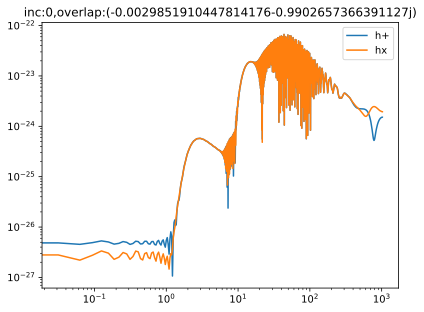

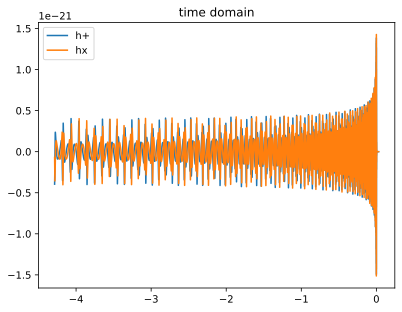

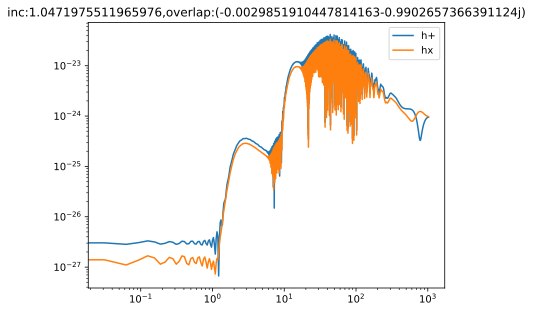

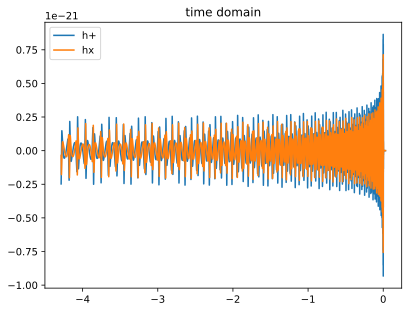

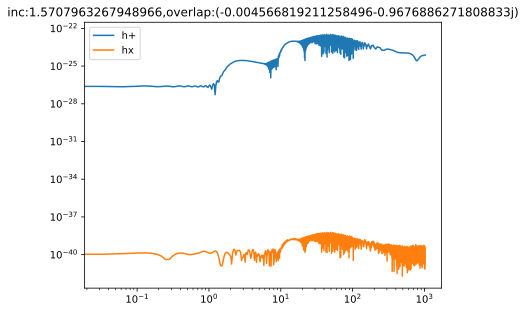

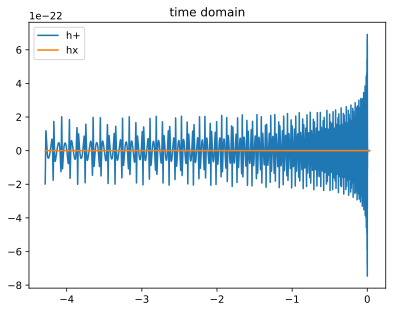

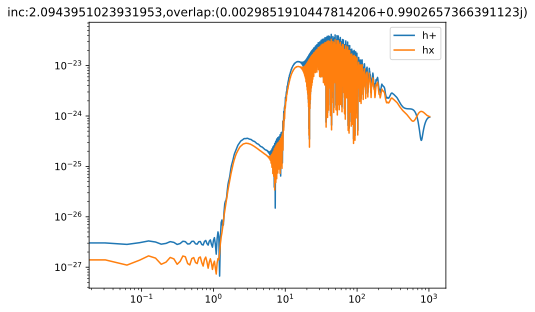

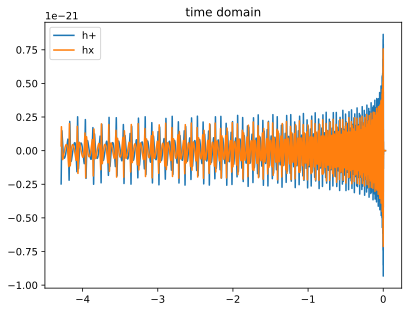

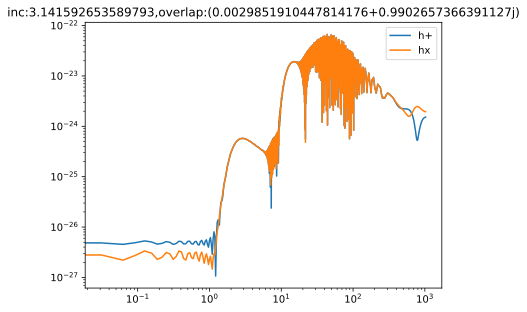

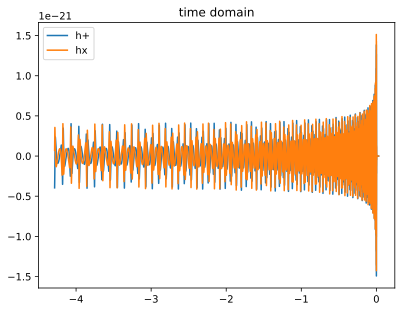

In [9]:
for i in [0,np.pi/3,np.pi/2,2*np.pi/3,np.pi]:
    plt.figure()
    par.update({"inclination":i})
    hp, hc = get_fd_waveform(**par)
    
    #hp.resize(tlen)
    #hc.resize(tlen)
    thiso = overlap_cplx(hp, hc, psd=psd, low_frequency_cutoff=f_low)
    #print('inc',i,'overlap',thiso)

    plt.loglog(hp.sample_frequencies,abs(hp),label='h+')
    plt.loglog(hc.sample_frequencies,abs(hc),label='hx')
    plt.legend()
    plt.title('inc:'+str(i)+',overlap:'+str(thiso))

    hpt,hct = get_td_waveform(**par)
    plt.figure()
    plt.plot(hpt.sample_times,hpt,label='h+')
    plt.plot(hct.sample_times,hct,label='hx')
    plt.legend()
    plt.title('time domain')

# Generate a lot of injections 

 12%|█████████████▏                                                                                           | 25/200 [00:04<00:48,  3.61it/s]/Users/yifanwang/miniconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: overflow encountered in func (vectorized)
  outputs = ufunc(*inputs)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.28it/s]


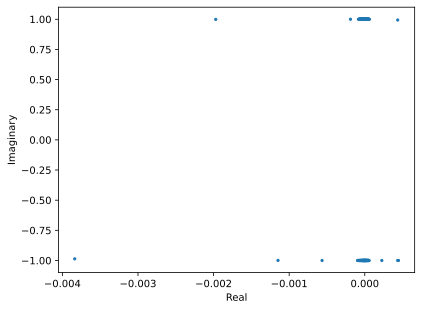

In [6]:
inj = distributions.uniform.Uniform(
            mass1=(5,50),
            mass2=(5,50),
            spin1z=(0,0.5),
            spin2z=(0,0.5),
            inclination=(0,np.pi),
            eccentricity=(0,0.5),
            rel_anomaly=(0,2*np.pi)
            ).rvs(size=200)

o = []
for i in tqdm( range(len(inj)) ):    
    thispar = copy.copy(par)
    for key in inj.dtype.names:
        thispar.update({key:inj[key][i]})
    #par.update({'inclination':np.pi/2})
    #print(thispar)
    try: 
        hp, hc = get_fd_waveform(**thispar)
    except ValueError as e:
        print(e)
        continue
        
    #hp.resize(tlen)
    #hc.resize(tlen)
    thiso = overlap_cplx(hp, hc, psd=psd, low_frequency_cutoff=f_low)
    o.append(thiso)


x = [ovalue.real for ovalue in o]  
y = [ovalue.imag for ovalue in o] 
plt.scatter(x, y, s=5) 
plt.ylabel('Imaginary') 
plt.xlabel('Real') 
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.show() 

In [7]:
m = np.argmax(np.abs(x))
print(x[m],y[m])
for key in inj.dtype.names:
    print(key,inj[key][m])

-0.003836815980022408 -0.9865749573847656
eccentricity 0.38695171257914496
inclination 0.3652105761317219
mass1 5.162009623964028
mass2 7.300175944478006
rel_anomaly 4.435073144322752
spin1z 0.05367204487471339
spin2z 0.46964322412072973
